In [1]:
import numpy as np
import pandas as pd
from decimal import Decimal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator

# Construção de um gráfico em papel milimetrado

## Criando conjuntos de dados de exemplo

In [45]:
dados1 = pd.DataFrame()
dados2 = pd.DataFrame()
dados3 = pd.DataFrame()

In [46]:
# fisexp 2 - densidade
dados1['x'] = np.array(range(260,314,6)) # massa em g
dados1['y'] = np.array([156, 162, 168, 174, 180, 186, 192, 198, 204])  # volume em ml
dados1['erro']  = np.array(np.ones(9))

# fisexp 2 - período do pêndulo
dados2['x'] = np.array([149.5, 137.5, 126.5, 113.5, 100.5]) # L em cm
dados2['y'] = np.array([2427, 2330, 2251, 2106, 1993]) # T em ms
dados2['erro']  = np.array([4, 4, 6, 7, 5])

# fisexp 2 - corda vibrante
dados3['x'] = np.array([334, 167, 111, 84, 67, 56, 48]) # comprimento de onda cm
dados3['y'] = np.array([12, 24, 36, 48, 59, 72, 83]) # frequencia Hz
dados3['erro']  = np.array(2*np.ones(7))

## Função para retornar todos os parâmetros do cálculo de escala

In [4]:
def escala(h, v, dados):
    dados.fillna(0,inplace=True)    
    
    # cálculo do delta    
    delta_x = dados['x'].max()-dados['x'].min()
    dados_y_max  = (dados['y']+dados['erro']).max()
    dados_y_min = (dados['y']-dados['erro']).min()
    delta_y = dados_y_max - dados_y_min
    
    #cálculo da escala natural
    escala_nat_x = delta_x / h 
    escala_nat_y = delta_y / v 
    
    # função auxiliar para o cálculo da escala boa
    def fexp(number):
        (sign, digits, exponent) = Decimal(number).as_tuple()
        return len(digits) + exponent - 1

    def fman(number):
        return float(Decimal(number).scaleb(-fexp(number)).normalize())
    
    # cálculo da escala boa
    def escala_boa(num):
        exp = 10**fexp(num)
        man = fman(num)
        if man == 5 or man == 2 or man == 1:
            return num
        if man > 5:
            return 10*exp
        if man > 2:
            return 5*exp
        if man > 1:
            return 2*exp
        return exp
    
    escala_boa_x = escala_boa(escala_nat_x)
    escala_boa_y = escala_boa(escala_nat_y)
    
    delta_bom_x = escala_boa_x*h
    delta_bom_y = escala_boa_y*v
    
    # cálculo dos limites
    limite_x = [ round(dados['x'].min()-(delta_bom_x-delta_x)/2, 10),
    round(dados['x'].max()+(delta_bom_x-delta_x)/2, 10) ]
    limite_y = [ round(dados_y_min -(delta_bom_y-delta_y)/2, 10),
    round(dados_y_max +(delta_bom_y-delta_y)/2, 10) ]
    
    # cálculo dos limites bons
    def limite_bom(esc, num):
        esc_cm = 10*esc
        return round(num / esc_cm) * esc_cm
    v_limite_bom = np.vectorize(limite_bom)
    
    limite_bom_x = [ round(limite_bom(escala_boa_x, limite_x[1])-h*escala_boa_x, 10),
                     round(limite_bom(escala_boa_x, limite_x[1]), 10) ]
                   
    limite_bom_y = [ round(limite_bom(escala_boa_y, limite_y[1])-v*escala_boa_y, 10),
                     round(limite_bom(escala_boa_y, limite_y[1]), 10) ]
    
    # cálculo das divisões
    div_x = [ round(limite_bom_x[0] + escala_boa_x*10*i,10) for i in range(0,int(h/10+1)) ]
    div_y = [ round(limite_bom_y[0] + escala_boa_y*10*i,10) for i in range(0,int(v/10+1)) ]
    
    # conversão para mm
    dados_mm = pd.DataFrame()
    dados_mm['x_mm'] = v_limite_bom(0.05, (dados['x'] - div_x[0]) / escala_boa_x)
    dados_mm['y_mm'] = v_limite_bom(0.05, (dados['y'] - div_y[0]) / escala_boa_y)
    dados_mm['erro_mm']  = v_limite_bom(0.05, dados['erro'] / escala_boa_y) # tamanho da incerteza
    
    return (delta_x, delta_y,
            escala_nat_x, escala_nat_y,
            escala_boa_x, escala_boa_y,
            delta_bom_x, delta_bom_y,
            limite_x, limite_y,
            limite_bom_x, limite_bom_y,
            div_x, div_y,
            dados_mm
           )
    

In [5]:
(delta_x, delta_y,
 escala_nat_x, escala_nat_y,
 escala_boa_x, escala_boa_y,
 delta_bom_x, delta_bom_y,
 limite_x, limite_y,
 limite_bom_x, limite_bom_y,
 div_x, div_y,
 dados_mm) = escala(180, 280, dados2)

## Salvando os resultados em um arquivo

In [6]:
import sys
sys.getdefaultencoding()

'utf-8'

In [7]:
arquivo = f'''
________________________________________________
Resultados eixo horizontal:

\u0394 = {round(delta_x,10)}

escala natural = {round(escala_nat_x,10)}

escala = {round(escala_boa_x,10)}

\u0394' = {round(delta_bom_x,10)}

limites = {limite_x}

limites corrigidos = {limite_bom_x}

escala de leitura 
{div_x}

________________________________________________
Resultados eixo vertical:

\u0394 = {round(delta_y,10)}

escala natural = {round(escala_nat_y,10)}

escala = {round(escala_boa_y,10)}

\u0394' = {round(delta_bom_y,10)}

limites = {limite_y}

limites corrigidos = {limite_bom_y}

escala de leitura 
{div_y}

________________________________________________
Dados em divisões 
{dados_mm}           
'''
print(arquivo)


________________________________________________
Resultados eixo horizontal:

Δ = 49.0

escala natural = 0.2722222222

escala = 0.5

Δ' = 90.0

limites = [80.0, 170.0]

limites corrigidos = [80.0, 170.0]

escala de leitura 
[80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0]

________________________________________________
Resultados eixo vertical:

Δ = 443

escala natural = 1.5821428571

escala = 2

Δ' = 560

limites = [1929.5, 2489.5]

limites corrigidos = [1920, 2480]

escala de leitura 
[1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480]

________________________________________________
Dados em divisões 
    x_mm   y_mm  erro_mm
0  139.0  253.5      2.0
1  115.0  205.0      2.0
2   93.0  165.5      3.0
3   67.0   93.0      3.5
4   41.0   36.5      2.5           



## Gráfico

In [65]:
def plot(h, v, dados, xlabel, ylabel):
# cálculo da escala
    (delta_x, delta_y,
     escala_nat_x, escala_nat_y,
     escala_boa_x, escala_boa_y,
     delta_bom_x, delta_bom_y,
     limite_x, limite_y,
     limite_bom_x, limite_bom_y,
     div_x, div_y,
     dados_mm) = escala(h, v, dados)
    
# proporcionalização
    ratio =(v/(np.array(div_y).max()-np.array(div_y).min()))/(h/(np.array(div_x).max()-np.array(div_x).min()))

    fig, ax = plt.subplots(figsize=(8.3, 11.7)) # tamanho A4

    ax.set_aspect(ratio)

    ax.set_title('Papel milimetrado')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(div_x[0],div_x[-1])
    ax.set_ylim(div_y[0],div_y[-1])

# grid lines
    ax.grid(which = "major")
    ax.grid(which = "minor", alpha = 0.2)
    ax.set_axisbelow(True)

    ax.tick_params(which = "minor", bottom = False, left = False)

#  major grid do eixo horizontal
    ax.xaxis.set_major_locator(FixedLocator(div_x))

#  major grid do eixo vertical
    ax.yaxis.set_major_locator(FixedLocator(div_y))

#  minor grid dividindo o major grid em 10
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# plot
    ax.errorbar(
        dados['x'],
        dados['y'],
        yerr = dados['erro'],
        marker='.',
        linestyle='none',
        color='green',
        label='dados experimentais',
        )
    fig.savefig(f'./imagens/{ylabel} x {xlabel}.png', format='png')

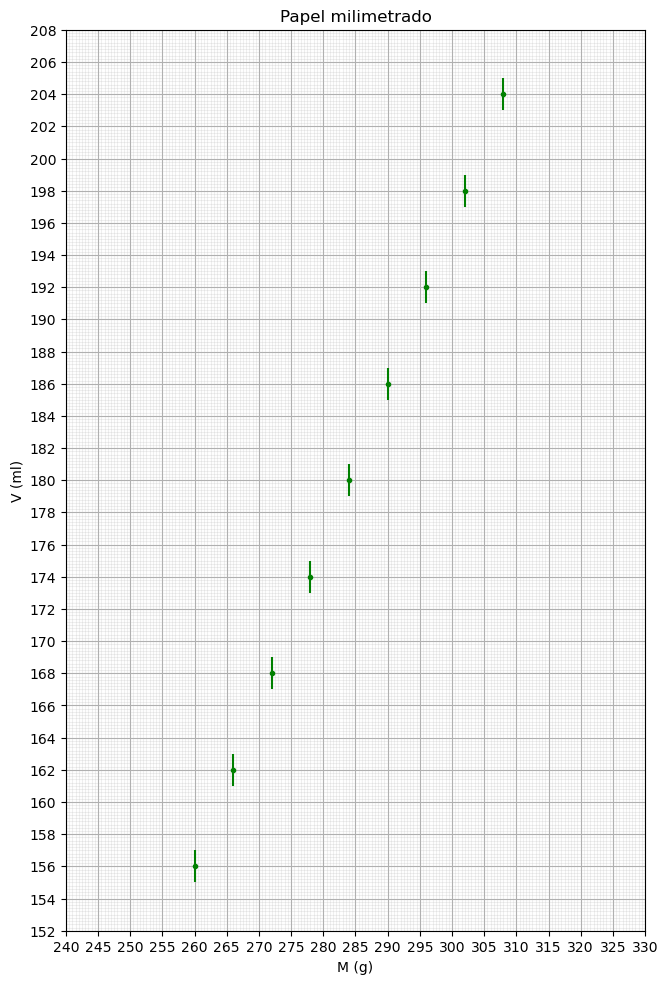

In [66]:
plot(180, 280, dados1, 'M (g)', 'V (ml)')

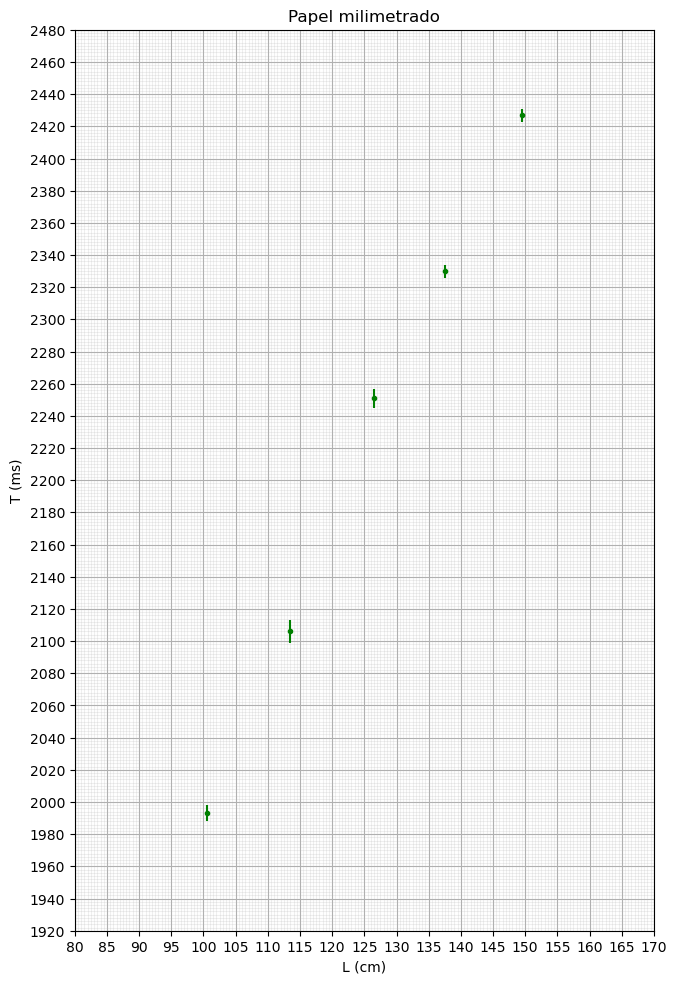

In [68]:
plot(180, 280, dados2, 'L (cm)', 'T (ms)')

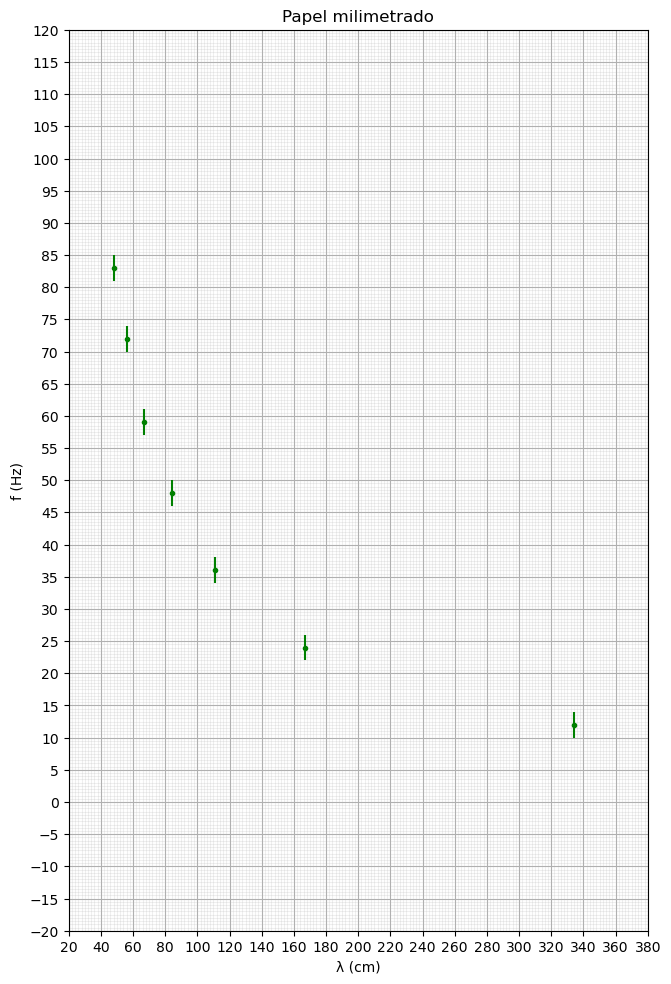

In [69]:
plot(180, 280, dados3, '\u03BB (cm)', 'f (Hz)')

### Construção do paralelogramo para gráficos lineares

In [75]:
x = dados1['x']
y = dados1['y']
y_err = dados1['erro']

In [143]:
# funções auxiliares

from math import log10, floor

def round_it(x, sig):
    return round(x, sig - int(floor(log10(abs(x)))) - 1)

def fexp(number):
        (sign, digits, exponent) = Decimal(number).as_tuple()
        return len(digits) + exponent - 1

def fman(number):
    return float(Decimal(number).scaleb(-fexp(number)).normalize())

In [80]:
modelo = LinearRegression().fit(np.array(dados1['x']).reshape(-1, 1), dados1['y'])
a = modelo.coef_[0]
b = modelo.intercept_
a, b

(1.0, -104.0)

Construção das retas paralelas

In [103]:
(y-y_err).max( ), a*x[list((y-y_err)).index((y-y_err).max( ))]

(203.0, 308.0)

In [103]:
(y-y_err).max( ), a*x[list((y-y_err)).index((y-y_err).max( ))]

(203.0, 308.0)

In [107]:
b1 = ( (y+y_err).max( )- a*x[list((y+y_err)).index((y+y_err).max( ))] )
y1 = a*x + b1
b1

-103.0

In [106]:
b2 = ( (y-y_err).min( )- a*x[list((y-y_err)).index((y-y_err).min( ))] )
y2 = a*x + b2
b2

-105.0

Cálculos dos coeficientes angulares e lineares máximo e mínimo

In [151]:
a_max = ( (a*x.max() + b1)-(a*x.min() + b2) )/ (x.max()-x.min())
a_min = ( (a*x.max() + b2)-(a*x.min() + b1) )/ (x.max()-x.min())
erro_a = round_it((a_max-a_min)/2, 1)
a_medio = (a_max + a_min)/2
erro_a = round_it((a_max - a_min)/2,1)
round(a_medio,abs(fexp(erro_a))), erro_a

(1.0, 0.04)

In [148]:
b_max = (a*x.max()+b1) - a*x.max()
b_min = (a*x.max()+b2) - a*x.max()
erro_b = round_it((b_max-b_min)/2,1)
b_medio = (b_max + b_min)/2
erro_b = round_it((b_max - b_min)/2,1)
round(b_medio, abs(fexp(erro_b))), erro_b

(-104.0, 1.0)

In [152]:
fexp(erro_a)

-2

In [134]:
y_max = a_max*x+b_min
y_min = a_min*x+b_max
y = a_medio*x+b_medio

In [156]:
paralelogramo = f'''
_______________________________________________________
Resultados dos coeficientes do método do paralelogramo:

reta com maior coeficiente angular:
a_max = {a_max}
b_min = {b_min}

reta com menor coeficiente angular:
a_min = {a_min}
b_max = {b_max}
_______________________________________________________
Resultados dos coeficientes da reta y = a x + b:

a = {a_medio}
erro de a = {erro_a}

b = {b_medio}
erro de b = {erro_b}

  
'''
print(paralelogramo)


_______________________________________________________
Resultados dos coeficientes do método do paralelogramo:

reta com maior coeficiente angular:
a_max = 1.0416666666666667
b_min = -105.0

reta com menor coeficiente angular:
a_min = 0.9583333333333334
b_max = -103.0
_______________________________________________________
Resultados dos coeficientes da reta y = a x + b:

a = 1.0
erro de a = 0.04

b = -104.0
erro de b = 1.0

  



# Plot do paralelogramo

In [158]:
def plot(h, v, dados, xlabel, ylabel):
# cálculo da escala
    (delta_x, delta_y,
     escala_nat_x, escala_nat_y,
     escala_boa_x, escala_boa_y,
     delta_bom_x, delta_bom_y,
     limite_x, limite_y,
     limite_bom_x, limite_bom_y,
     div_x, div_y,
     dados_mm) = escala(h, v, dados)
    
# proporcionalização
    ratio =(v/(np.array(div_y).max()-np.array(div_y).min()))/(h/(np.array(div_x).max()-np.array(div_x).min()))

    fig, ax = plt.subplots(figsize=(8.3, 11.7)) # tamanho A4

    ax.set_aspect(ratio)

    ax.set_title('Papel milimetrado')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(div_x[0],div_x[-1])
    ax.set_ylim(div_y[0],div_y[-1])

# grid lines
    ax.grid(which = "major")
    ax.grid(which = "minor", alpha = 0.2)
    ax.set_axisbelow(True)

    ax.tick_params(which = "minor", bottom = False, left = False)

#  major grid do eixo horizontal
    ax.xaxis.set_major_locator(FixedLocator(div_x))

#  major grid do eixo vertical
    ax.yaxis.set_major_locator(FixedLocator(div_y))

#  minor grid dividindo o major grid em 10
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# plot
    ax.errorbar(
        dados['x'],
        dados['y'],
        yerr = dados['erro'],
        marker='.',
        linestyle='none',
        color='green',
        label='dados experimentais',
        )
# paralelogramo
    ax.plot(
        x,
        ((a_max+a_min)/2)*x+((b_max+b_min)/2),
        linestyle='-',
        color='red',
        label='ajuste linear',
    )
    ax.plot(
        x,
        a_max*x+b_min,
        linestyle='--',
        color='orange',
        label='método do paralelogramo',
    )
    ax.plot(
        x,
        a_min*x+b_max,
        linestyle='--',
        color='orange',

    )
    ax.plot(
        x,
        a_max*x+b_min,
        linestyle=':',
        color='orange',
    )
    ax.plot(
        x,
        a_max*x+b_min,
        linestyle=':',
        color='orange',
    )

    ax.legend(loc='upper left', ncols=1)
    fig.savefig(f'./imagens/{ylabel} x {xlabel}.png', format='png')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

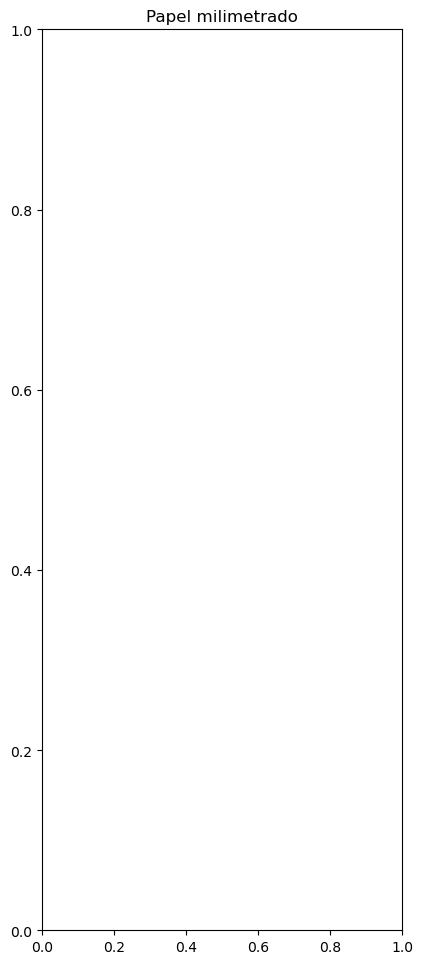

In [161]:
plot(180, 280, dados1, x, y)